In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
N_TRIAL = 30000
N_ARMS = 100
N_FEATURE = 3
M = 66
np.random.seed(123)

In [ ]:
# Beta = np.genfromtxt('Beta.csv',delimiter=',')
# X_1 = np.genfromtxt('X.csv',delimiter=',')
# Y_1 = np.genfromtxt('Y.csv',delimiter=',')
# E = np.genfromtxt('E.csv',delimiter=',')
import os
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
# Beta = np.genfromtxt('/content/drive/My Drive/Colab Notebooks/MAB/Beta.csv',delimiter=',')
# X_1 = np.genfromtxt('/content/drive/My Drive/Colab Notebooks/MAB/X.csv',delimiter=',')
# Y_1 = np.genfromtxt('/content/drive/My Drive/Colab Notebooks/MAB/Y.csv',delimiter=',')
# W = np.genfromtxt('/content/drive/My Drive/Colab Notebooks/MAB/W.csv',delimiter=',')

# Beta = np.genfromtxt('/content/drive/My Drive/Colab Notebooks/MAB/Beta(newsettings).csv',delimiter=',')
# # X_1 = np.genfromtxt('/content/drive/My Drive/Colab Notebooks/MAB/X.csv',delimiter=',')
# Y_1 = np.genfromtxt('/content/drive/My Drive/Colab Notebooks/MAB/Y(newsettings).csv',delimiter=',')
# W = np.genfromtxt('/content/drive/My Drive/Colab Notebooks/MAB/W(newsettings).csv',delimiter=',')

Beta = np.genfromtxt('/content/drive/My Drive/Colab Notebooks/MAB/Beta(noise_rsc2).csv',delimiter=',')
# X_1 = np.genfromtxt('/content/drive/My Drive/Colab Notebooks/MAB/X.csv',delimiter=',')
Y_1 = np.genfromtxt('/content/drive/My Drive/Colab Notebooks/MAB/Y(noise_rsc2).csv',delimiter=',')
W = np.genfromtxt('/content/drive/My Drive/Colab Notebooks/MAB/W(noise_rsc2).csv',delimiter=',')

Mounted at /content/drive


In [ ]:
X_1_lst = []
for T in np.arange(N_TRIAL):
  X_1t_lst = []
  for arm in np.arange(N_ARMS):
    temp = []
    temp.append(1)
    temp.append(0.001*(T+1))
    temp.append((0.001*(T+1))**2)
    X_1t_lst.append(np.array(temp))
    # np.append(X_1, X_1t)
  X_1_lst.append(np.array(X_1t_lst))
X_1 = np.array(X_1_lst)

In [ ]:
oracle_lst = []
true_choice = []
new_y = -1 * Y_1 + 30 #
for t in np.arange(N_TRIAL):
  # Find indices of M highest arms
  all_reward_t = [new_y.T[t, arm] for arm in np.arange(N_ARMS)]
  chosen_arms = np.array(all_reward_t).argsort()[-M:][::-1]
#   idx = np.argpartition(np.array(all_reward_t), -M)[-M:]
#   chosen_arms = idx[np.argsort(-(np.array(all_reward_t))[idx])]
  # Sum of M highest rewards
  oracle_payoff_t = np.sum([new_y.T[t, choice] for choice in chosen_arms])
  # Append to the list
  oracle_lst.append(oracle_payoff_t)
  true_choice.append(chosen_arms)
  # if t % 3000 == 0:
  #   print('TRIAL:',t,'DONE', '| arm selected:', chosen_arms)
oracle_case1 = np.array(oracle_lst)


In [ ]:
def make_regret(payoff, oracle):
    return np.cumsum(oracle - payoff)

def plot_regrets(results, oracle):
    [plt.plot(make_regret(payoff=x['r_payoff'], oracle=oracle), label="alpha: "+str(alpha)) for (alpha, x) in results.items()]

In [ ]:
def plot_l2_norm_diff(results, true_theta, n_trial, n_arms):
    [plt.plot(make_l2_norm_diff(x['theta'], true_theta, n_trial, n_arms), label="alpha: "+str(alpha)) for (alpha, x) in results.items()]
def make_l2_norm_diff(theta, true_theta, n_trial, n_arms): #, true_choice
    diff = []
    for t in range(n_trial):
        diff_t = 0
        for arm in range(n_arms):
#             diff_vec = theta[t, arm] - true_theta[arm] #true_choice[t][i]
            diff_vec = theta[t, arm] - (-true_theta[arm]) #true_choice[t][i]
#             t_dist = np.sqrt(np.linalg.norm(theta[t, arm], ord=2))
#             if t_dist != 0:
#                 t_norm = theta[t, arm]/t_dist
#                 diff_vec = t_norm - (-true_theta[arm]/np.sqrt(np.linalg.norm(true_theta[arm], ord=2)))
# #                 diff_vec = theta[t, arm]/t_dist - (-true_theta[arm]/np.sqrt(np.linalg.norm(true_theta[arm], ord=2)))
#             else:
#                 diff_vec = theta[t, arm] - (-true_theta[arm]/np.sqrt(np.linalg.norm(true_theta[arm], ord=2)))
            diff_t += np.linalg.norm(diff_vec, ord=2)
        diff.append(diff_t)
    return np.array(diff)

In [ ]:
def linUCB(lda, alpha, X, Y, m, oracle, true_choice):
    print("linUCB with alpha:", alpha)
    n_trial, n_arms, n_feature = X.shape
    
    # 1.Initialization
    c_payoff = np.empty(n_trial)
    c_payoff[0] = 0
    r_payoff = np.empty(n_trial)
    cum_regret = np.empty(n_trial)
    r_payoff[0] = 0
    arm_choice = np.empty(shape=(n_trial, m), dtype=int)
    theta = np.empty(shape=(n_trial, n_arms, n_feature)) 
    p = np.empty(shape=(n_trial, n_arms))
    acc = np.empty(shape=(n_trial, n_arms))


    pred_reward = np.empty(shape=(n_trial, n_arms)) 
    ucb = np.empty(shape=(n_trial, n_arms))
    selected_pred = np.empty(n_trial)
    opt_pred = np.empty(n_trial)  
    selected_err = np.empty(n_trial)
    opt_err = np.empty(n_trial)
    opt_payoff = np.empty(n_trial)
    
    mse_sel = np.empty(n_trial)
    mse_opt = np.empty(n_trial)
    
    A = np.array([lda * np.diag(np.ones(shape=n_feature)) for _ in np.arange(n_arms)])
    b = np.array([np.zeros(shape=n_feature) for _ in np.arange(n_arms)])

    # 2. Algorithm
    for t in np.arange(n_trial): 
        for a in np.arange(n_arms):
            inv_A       = np.linalg.inv(A[a])
            theta[t, a] = inv_A.dot(b[a])
            pred_reward[t, a] = theta[t, a].dot(X[t, a])
            ucb[t, a] = alpha * np.sqrt(X[t, a].dot(inv_A).dot(X[t, a]))
            p[t, a] = pred_reward[t, a] + ucb[t, a]
            # p[t, a]     = theta[t, a].dot(X[t, a]) + alpha * np.sqrt(X[t, a].dot(inv_A).dot(X[t, a]))
            acc[t, a]   = p[t, a] - Y[t, a]
        # selected_err[t] = sum([])
        # opt_err[t] = sum([pred_reward[t, a] for a in true_choice[t]])
        # Choose m best arms
        idx = np.argpartition(p[t], -m)[-m:]
        chosen_arms = idx[np.argsort(-(p[t])[idx])]

        selected_pred[t] = sum([pred_reward[t, a] for a in chosen_arms])
        opt_pred[t] = sum([pred_reward[t, a] for a in true_choice[t]])

        for i in np.arange(m):
          arm_choice[t][i] = chosen_arms[i]
        
        # Update A and b
        for chosen_arm in arm_choice[t]:
          A[chosen_arm] += np.outer(X[t, chosen_arm], X[t, chosen_arm].T)
          b[chosen_arm] += Y[t, chosen_arm] * X[t, chosen_arm]
        
        # Cumulative rewards
        if t == 0:
            c_payoff[t] = np.sum([Y[t, choice] for choice in arm_choice[t]])
        else:
            c_payoff[t]   = c_payoff[t-1] + np.sum([Y[t, choice] for choice in arm_choice[t]])

        r_payoff[t] = np.sum([Y[t, choice] for choice in arm_choice[t]])
        cum_regret[t] = np.sum(oracle[0:t+1] - r_payoff[0:t+1])

        opt_payoff[t] = np.sum([Y[t, choice] for choice in true_choice[t]])
        selected_err[t] = selected_pred[t] - r_payoff[t]
        opt_err[t] = opt_pred[t] - opt_payoff[t]

        mse_sel[t] = np.sum(np.square(pred_reward[t, a] - Y[t, a]) for a in chosen_arms)/m
        mse_opt[t] = np.sum(np.square(pred_reward[t, a] - Y[t, a]) for a in true_choice[t])/m

        # if (t+1) % 15000 == 0:
        #     print('TRIAL:',t,'DONE', '| arm selected:', chosen_arms)
        if (t+1) % 15000 == 0:
            print('TRIAL:',t,'DONE', '| cum_regret:', cum_regret[t])

    return dict(mse_sel=mse_sel, mse_opt=mse_opt, theta=theta, p=p, arm_choice = arm_choice, r_payoff=r_payoff, c_payoff=c_payoff, A=A, acc=acc, selected_err=selected_err, opt_err=opt_err)

In [ ]:
print('M:', M)
alpha_to_test = [1.5,1.75,2,2.5,3,3.25,3.5,4]#[0.05,0.1,0.15,0.2]#[3.25]#

results_dict = {alpha: linUCB(lda = 0.3, alpha = alpha, X=X_1, Y=(-1 * Y_1 + 30).T, m=M, oracle=oracle_case1, true_choice=true_choice)\
                for alpha in alpha_to_test} #(-1 * Y_2)

M: 66
linUCB with alpha: 1.5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


TRIAL: 14999 DONE | cum_regret: 8249.416867947311
TRIAL: 29999 DONE | cum_regret: 9730.648126756898
linUCB with alpha: 1.75
TRIAL: 14999 DONE | cum_regret: 4947.893618475136
TRIAL: 29999 DONE | cum_regret: 6500.128812739568
linUCB with alpha: 2
TRIAL: 14999 DONE | cum_regret: 3684.558784605332
TRIAL: 29999 DONE | cum_regret: 5320.941820294119
linUCB with alpha: 2.5
TRIAL: 14999 DONE | cum_regret: 4711.339622426272
TRIAL: 29999 DONE | cum_regret: 6474.170068533789
linUCB with alpha: 3
TRIAL: 14999 DONE | cum_regret: 5898.480839654398
TRIAL: 29999 DONE | cum_regret: 7808.940474381065
linUCB with alpha: 3.25
TRIAL: 14999 DONE | cum_regret: 6554.447259249909
TRIAL: 29999 DONE | cum_regret: 8538.427088490429
linUCB with alpha: 3.5
TRIAL: 14999 DONE | cum_regret: 7167.284296693353
TRIAL: 29999 DONE | cum_regret: 9239.903437494128
linUCB with alpha: 4
TRIAL: 14999 DONE | cum_regret: 8437.483423143376
TRIAL: 29999 DONE | cum_regret: 10675.143592647393


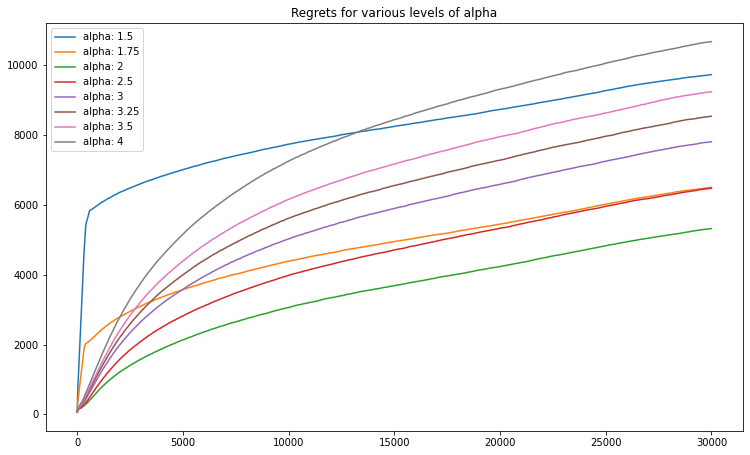

In [ ]:
# Plot regrets for various levels of alpha
plt.figure(figsize=(12.5, 7.5))
plot_regrets(results_dict, oracle_case1)
plt.legend()
plt.title("Regrets for various levels of alpha")
plt.show()

In [ ]:
# Beta_reshape = Beta.T
# # Plot l2_norm difference for various levels of alpha
# plt.figure(figsize=(12.5, 7.5))
# plot_l2_norm_diff(results_dict, Beta_reshape, n_trial=N_TRIAL, n_arms=N_ARMS, n_feature=N_FEATURE, FInv_Init=FInv_Init)
# plt.legend()
# plt.title("L2_norm difference of LinUCB")
# plt.show()

In [ ]:
from google.colab import files
# test_lst = [make_regret(payoff=x['r_payoff'], oracle=oracle_case1) for (alpha, x) in results_dict.items()]
# df2 = pd.DataFrame(test_lst[0])
# df2.to_csv('C1_LinUCB_regret_66_rsc2.csv', header=False)
# files.download('C1_LinUCB_regret_66_rsc2.csv')

In [ ]:
from google.colab import files
# sel_err_lst = results_dict[3.25]['mse_sel']
# df_s = pd.DataFrame(sel_err_lst)
# df_s.to_csv('C1_LinUCB_sel_err_66_rsc2_mse.csv', header=False)
# files.download('C1_LinUCB_sel_err_66_rsc2_mse.csv')
# opt_err_lst = results_dict[3.25]['mse_opt']
# df_o = pd.DataFrame(opt_err_lst)
# df_o.to_csv('C1_LinUCB_opt_err_66_rsc2_mse.csv', header=False)
# files.download('C1_LinUCB_opt_err_66_rsc2_mse.csv')

In [ ]:
# 0 = 0, 1 = 1, 2 = 2.5, 3 = 5, 4 = 10, 5 = 20
# export l2
# test_lst2 = [make_l2_norm_diff(x['theta'], Beta_reshape, N_TRIAL, N_ARMS) for (alpha, x) in results_dict.items()]
# df2 = pd.DataFrame(test_lst2[2]) #index 
# df2.to_csv('LinUCB25_l2norm.csv', header=False)

# export regret data
# test_lst = [make_regret(payoff=x['r_payoff'], oracle=oracle_case1) for (alpha, x) in results_dict.items()]
# df = pd.DataFrame(test_lst[0]) #index 4 is for alpha = 10 
# df.to_csv('C1_LinUCB_regret_33_rsc2.csv', header=False)
# files.download('C1_LinUCB_regret_33_rsc2.csv')